## Estimating m from a sample of pairwise labels

In this example, we estimate the m probabilities of the model from a table containing pairwise record comparisons which we know are 'true' matches.  For example, these may be the result of work by a clerical team who have manually labelled a sample of matches.

The table must be in the following format:

|source_dataset_l|unique_id_l|source_dataset_r|unique_id_r|
|----------------|-----------|----------------|-----------|
|df_1            |1          |df_2            |2          |
|df_1            |1          |df_2            |3          |

It is assumed that every record in the table represents a certain match.

Note that the column names above are the defaults.  They should correspond to the values you've set for [`unique_id_column_name`](https://moj-analytical-services.github.io/splink/settings_dict_guide.html#unique_id_column_name) and  [`source_dataset_column_name`](https://moj-analytical-services.github.io/splink/settings_dict_guide.html#source_dataset_column_name), if you've chosen custom values.



In [1]:
import pandas as pd 
import altair as alt
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [2]:
pairwise_labels = pd.read_csv("./data/pairwise_labels_to_estimate_m.csv")
pairwise_labels

,unique_id_l,source_dataset_l,unique_id_r,source_dataset_r
0,0,fake_1000,3,fake_1000
1,1,fake_1000,3,fake_1000
2,2,fake_1000,3,fake_1000
3,4,fake_1000,5,fake_1000
4,7,fake_1000,10,fake_1000
...,...,...,...,...
2026,978,fake_1000,979,fake_1000
2027,985,fake_1000,986,fake_1000
2028,624,fake_1000,626,fake_1000
2029,625,fake_1000,626,fake_1000


We now proceed to estimate the Fellegi Sunter model:

In [3]:
df = pd.read_csv("./data/fake_1000.csv")
df.head(2)

,unique_id,first_name,surname,dob,city,email,cluster
0,0,Robert,Alan,1971-06-24,NaN,robert255@smith.net,0
1,1,Robert,Allen,1971-05-24,NaN,roberta25@smith.net,0


In [4]:
from splink.duckdb.duckdb_linker import DuckDBLinker
from splink.duckdb import duckdb_comparison_library as cl

settings = {
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
    ],
    "comparisons": [
        cl.levenshtein_at_thresholds("first_name", 2),
        cl.levenshtein_at_thresholds("surname", 2),
        cl.levenshtein_at_thresholds("dob"),
        cl.exact_match("city", term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("email"),
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
}

In [5]:
linker = DuckDBLinker(df, settings, set_up_basic_logging=False)
deterministic_rules = [
    "l.first_name = r.first_name and levenshtein(r.dob, l.dob) <= 1",
    "l.surname = r.surname and levenshtein(r.dob, l.dob) <= 1",
    "l.first_name = r.first_name and levenshtein(r.surname, l.surname) <= 2",
    "l.email = r.email"
]

linker.estimate_probability_two_random_records_match(deterministic_rules, recall=0.7)


In [6]:
linker.estimate_u_using_random_sampling(max_pairs=1e6)

In [7]:
# Register the pairwise labels table with the database, and then use it to estimate the m values
labels_df = linker.register_labels_table(pairwise_labels, overwrite=True)
linker.estimate_m_from_pairwise_labels(labels_df)


# Not if the labels table already existing in the dataset you could run
# linker.estimate_m_from_pairwise_labels("labels_tablename_here")


In [8]:
training_blocking_rule = "l.first_name = r.first_name"
linker.estimate_parameters_using_expectation_maximisation(training_blocking_rule)

<EMTrainingSession, blocking on l.first_name = r.first_name, deactivating comparisons first_name>

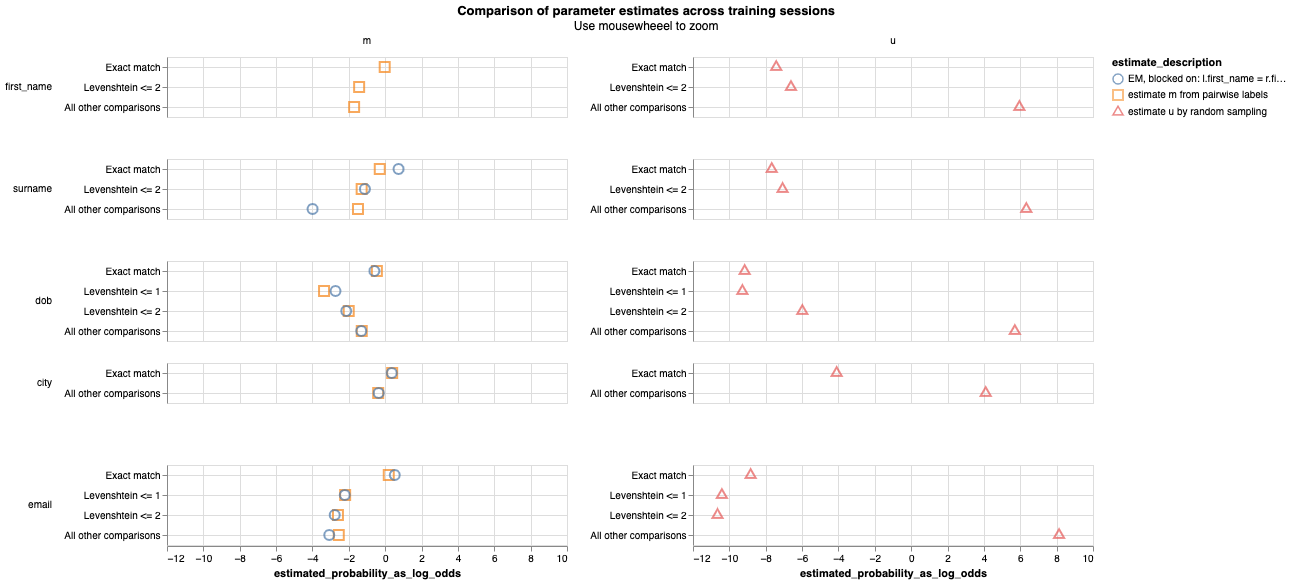

In [9]:
linker.parameter_estimate_comparisons_chart()

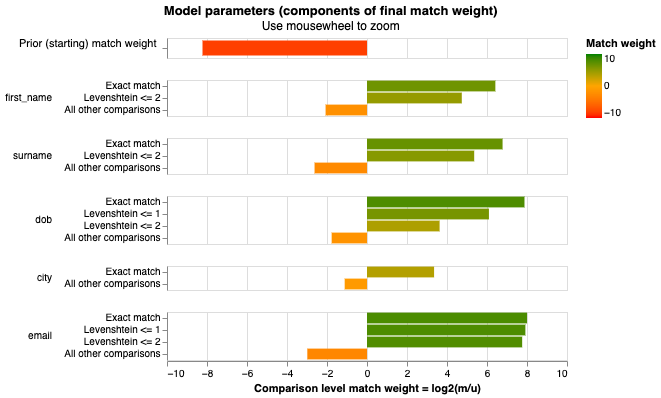

In [10]:
linker.match_weights_chart()